In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import statsmodels.api as sm

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

%matplotlib inline

In [3]:
data = pd.read_csv("performance_year_financial_and_quality_results_puf_2020_01_01.csv")

# Background

In 2019, the United States collectively spent \\$ 3.8 trillion on healthcare - more than \$11,000 per person. This is nearly 15% higher than it was at the start of decade, with no obvious signs of slowing; at current rates, our healthcare costs are expected to rise to almost \\$7 trillion by 2028. Much of these costs get passed on to consumers in the form of higher premiums, higher deductibles, and higher contributions to support dwindling Medicare funds. Needless to say, the state of our healthcare industry is very grim, and we need to take drastic cost containment actions over the coming decade to slow or reverse the trend we're seeing. (source: https://www.investopedia.com/insurance/why-do-healthcare-costs-keep-rising/)

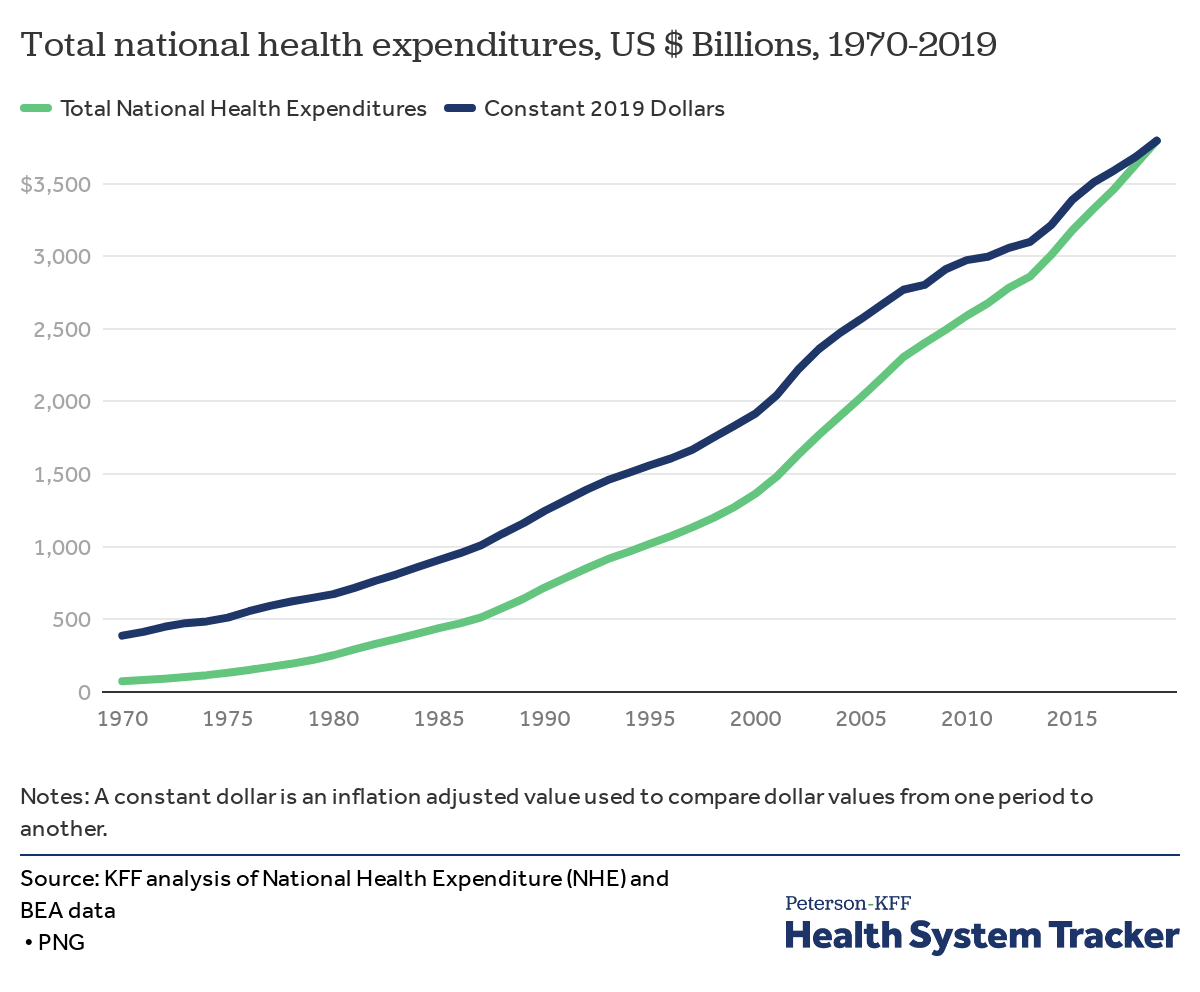

The biggest drivers of our healthcare spending are hospital care (31\% of overall spend) and physician services (20\% of overall spend) - broadly, these two collectively encompass care that Americans receive from physician organizations. The vast majority of these providers are paid in a Fee-For-Service (FFS) fashion, wherein they are paid by insurers for completing services (for instance, conducting an annual physical, doing an MRI, completing a surgery, etc.). Put otherwise, physicians complete services, submit bills to insuerers, and insurers reimburse them per negotiated rates. As one can imagine, this can create a perverse incentive where physicians are reimbursed more for doing more, thereby creating a system that heavily rewards "overtreatment" and does not motivate accountability for good outcomes. There has been much dialogue about a new payment paradigm named "Value-Based Care", wherein physicians assume different levels of risk for managing patient populations and face financial penalities for poor outcomes (for instance, if a patient is admitted to the emergency room for an avoidable reason, the physician group responsible for that patient's care is financially penalized). Our aim is to evaluate results from one such program - the Medicare Shared Savings Program (MSSP).  

Medicare is a public insurance in the United States that primarily covers individuals 65 years and older, but also covers people with certain disabilities (chiefly, End-Stage-Renal-Disease, i.e. kidney failure). The Medicare Shared Savings Program traces its roots to the George W. Bush administration, but was formally entrenched following the passage of the Affordable Care Act (ACA) in 2012. It is designed to promote a value-based-care arrangement called an Accountable Care Organization (ACO), in which groups of doctors, hospitals, and other health care providers, who come together voluntarily to give coordinated high-quality care to their Medicare patients. The details of the program are extremely complicated (outlined here: https://www.cms.gov/Medicare/Medicare-Fee-for-Service-Payment/sharedsavingsprogram/Downloads/Shared-Savings-Losses-Assignment-Spec-V6.pdf). On a high level, if a physician group decides to partake in MSSP, CMS (the insitution that administers Medicare) computes the expected costs for the patients under the ACO's care, and then reimburses the physician group based on how much they save relative to that expected cost (also known as the "benchmark"). There are different risk tracks (outlined below), which enable providers to assume different levels of upside and downside risk. Generally, the more downside potential the ACO is willing to assume (i.e. in the case that they exceed expected costs, they will have to pay Medicare a portion of those losses), the more upside potential they have (source: https://www.cms.gov/Medicare/Medicare-Fee-for-Service-Payment/sharedsavingsprogram/Downloads/ssp-aco-participation-options.pdf). 

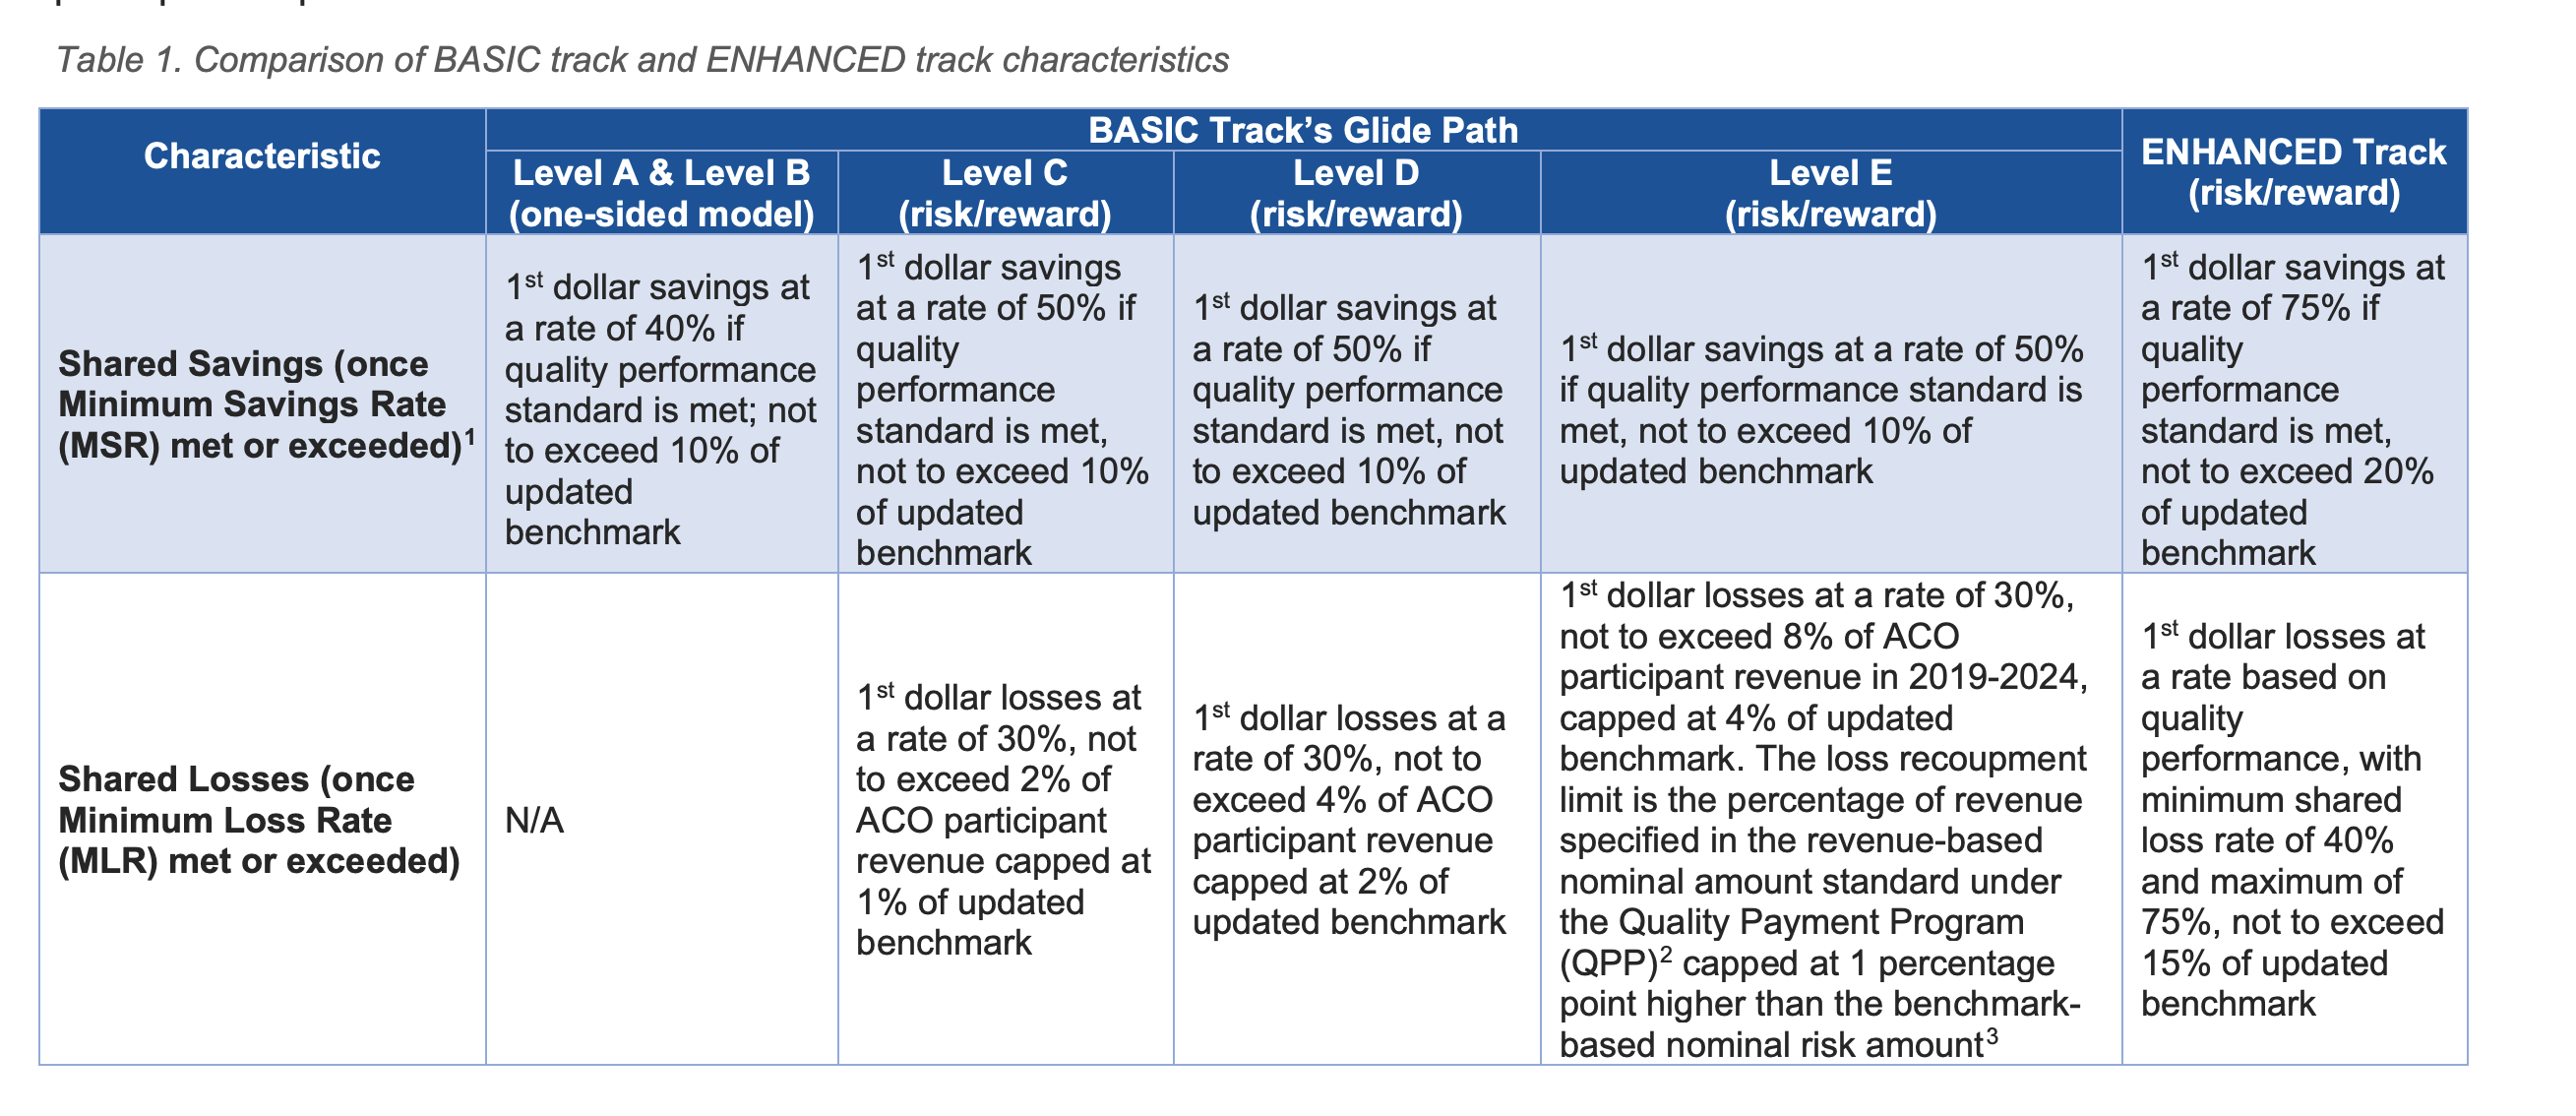

Our goal in this project is to use publicly available MSSP data to predict drivers of savings in the MSSP program. The MSSP public use file contains over 200 characteristics on each ACO that participates in the program, and our primarily outcome variable will be the gross margin saving percentage that the ACO produced in the January 2020-December 2020 period (Total Benchmark Expenditures Minus Assigned Beneficiary Expenditures as a percent of Total Benchmark Expenditures). 

# EDA

In [16]:
#Program Facts

#Number of ACOs
print(f"Number of ACOs: {len(data)}")

#Total Number of Attributed Beneficiaries
print(f"Total Number of Beneficiaries: {sum(data['N_AB'])}")

#Avg Number of Attributed Beneficiaries 
print(f"Average Number of Beneficiaries per ACO: {sum(data['N_AB'])/len(data):.0f}")

Number of ACOs: 513
Total Number of Beneficiaries: 10614589
Average Number of Beneficiaries per ACO: 20691


Total Savings Generated by ACOs: $4144939915
Total Savings Generated for CMS: $1861215125
Total Savings Generated per ACO: $8079805
Total Savings Generated  per Beneficary: $390


/Users/eshan/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


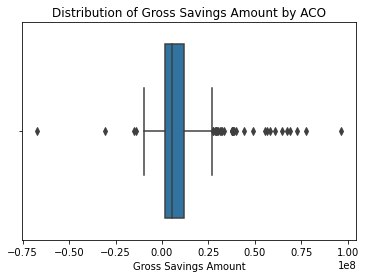

/Users/eshan/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


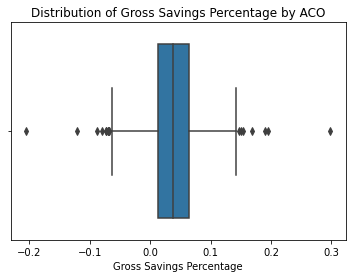

In [212]:
#Program Results

#Savings Generated by ACOs Relative to Benchmark
savings_generated = sum(data['BnchmkMinExp'])
print(f"Total Savings Generated by ACOs: ${savings_generated}")

#Total Savings Generated for CMS post ACO payouts
savings_to_CMS = sum(data['BnchmkMinExp'])-sum(data['EarnSaveLoss'])
print(f"Total Savings Generated for CMS: ${savings_to_CMS}")

#Savings per ACO
savings_per_ACO = savings_generated / len(data)
print(f"Total Savings Generated per ACO: ${savings_per_ACO:.0f}")

#Savings per beneficiary
savings_per_capita = savings_generated / sum(data['N_AB'])
print(f"Total Savings Generated  per Beneficary: ${savings_per_capita:.0f}")

#Distribution of Savings Generated by ACOs - Gross Savings/(Loss) Amount
sns.boxplot(data['BnchmkMinExp'])
plt.xlabel("Gross Savings Amount")
plt.title("Distribution of Gross Savings Amount by ACO")
plt.show()


#Distribution of Savings Generated by ACOs - Gross Savings/(Loss) Percentage
sns.boxplot(data['Sav_rate'])
plt.xlabel("Gross Savings Percentage")
plt.title("Distribution of Gross Savings Percentage by ACO")
plt.show()



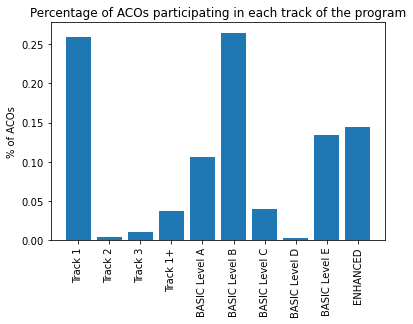

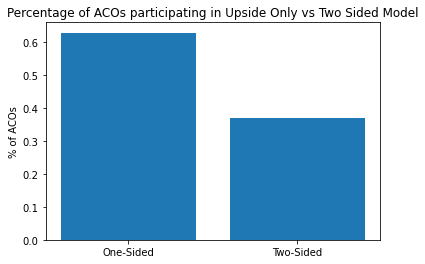

In [50]:
#ACO Characteristics

#Risk Track - Track 1, 2, 3, 1+, BASIC Levels A-E, ENHANCED
x = ["Track 1", "Track 2", "Track 3", "Track 1+", "BASIC Level A", "BASIC Level B", 
    "BASIC Level C","BASIC Level D","BASIC Level E","ENHANCED"]
y = [np.average(data['Current_Track_1']), np.average(data['Current_Track_2']), 
     np.average(data['Current_Track_3']), np.average(data['Current_Track_1_Plus']),
    np.average(data['Current_BASIC_A']), np.average(data['Current_BASIC_B']),
    np.average(data['Current_BASIC_C']), np.average(data['Current_BASIC_D']),
    np.average(data['Current_BASIC_E']), np.average(data['Current_ENHANCED']),
    ]

plt.bar(x, y)
plt.ylabel("% of ACOs")
plt.title("Percentage of ACOs participating in each track of the program")
plt.xticks(rotation="vertical")
plt.show()

#print(sum(y)) - sanity check

#Risk Profile - Track 1, BASIC A, and BASIC B are upside only, the remainder are two-sided models

#print(pd.unique(data['Risk_Model']))

x = ["One-Sided", "Two-Sided"]
y = [len(data[data['Risk_Model'] == x[0]])/len(data), len(data[data['Risk_Model'] == x[1]])/len(data)]

plt.bar(x, y)
plt.ylabel("% of ACOs")
plt.title("Percentage of ACOs participating in Upside Only vs Two Sided Model")
plt.show()


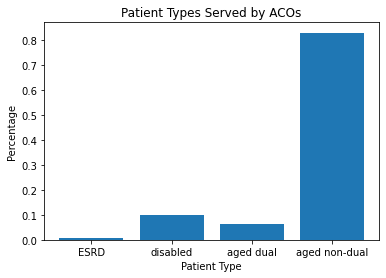

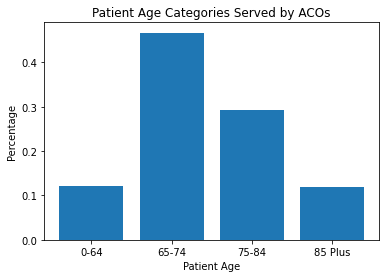

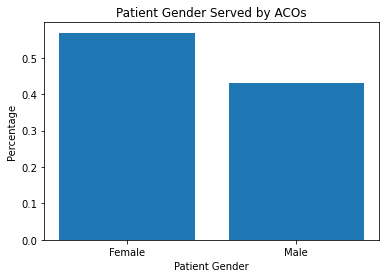

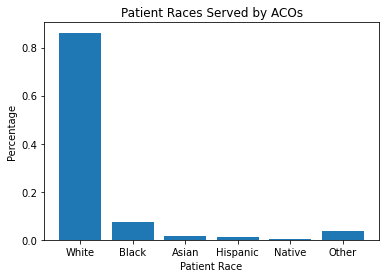

In [61]:
#Patient population

'''
CMS reports beneficiaries falling into certain categories (ESRD, Disabled, etc.) based on a notion of 
Patient-Years". This reflects the number of patients in each category under the care of the ACO, adjusted for how
many months of the current period the patient is under the ACO's care for.
'''

total_person_years = sum(data['N_AB_Year_PY'])
esrd = sum(data['N_AB_Year_ESRD_PY'])
disabled = sum(data['N_AB_Year_DIS_PY'])
aged_dual = sum(data['N_AB_Year_AGED_Dual_PY'])
aged_nondual = sum(data['N_AB_Year_AGED_NonDual_PY'])

x = ['ESRD', 'disabled', 'aged dual', 'aged non-dual']
y = np.array([esrd, disabled, aged_dual, aged_nondual])/total_person_years
plt.bar(x, y)
plt.title("Patient Types Served by ACOs")
plt.xlabel("Patient Type")
plt.ylabel("Percentage")
plt.show()

#Look at distribution of age

aged_0_64 = sum(data['N_Ben_Age_0_64'])
aged_65_74 = sum(data['N_Ben_Age_65_74'])
aged_75_84 = sum(data['N_Ben_Age_75_84'])
aged_85_plus = sum(data['N_Ben_Age_85plus'])

total = aged_0_64+aged_65_74+aged_75_84+aged_85_plus

x = ["0-64", "65-74", "75-84", "85 Plus"]
y = np.array([aged_0_64, aged_65_74, aged_75_84, aged_85_plus])
y  = y/sum(y)
plt.bar(x, y)
plt.title("Patient Age Categories Served by ACOs")
plt.xlabel("Patient Age")
plt.ylabel("Percentage")
plt.show()

#Look at distribution of gender

female = sum(data['N_Ben_Female'])
male = sum(data['N_Ben_Male'])

x=["Female", "Male"]
y=np.array([female, male])
y = y/sum(y)

plt.bar(x, y)
plt.title("Patient Gender Served by ACOs")
plt.xlabel("Patient Gender")
plt.ylabel("Percentage")
plt.show()

#Look at distribution of race

white = sum(data['N_Ben_Race_White'])
black = sum(data['N_Ben_Race_Black'])
asian = sum(data['N_Ben_Race_Asian'])
hispanic = sum(data['N_Ben_Race_Hisp'])
native = sum(data['N_Ben_Race_Native'])
other = sum(data['N_Ben_Race_Other'])



x=["White", "Black", "Asian", "Hispanic", "Native", "Other"]
y=np.array([white, black, asian, hispanic, native, other])
y = y/sum(y)

plt.bar(x, y)
plt.title("Patient Races Served by ACOs")
plt.xlabel("Patient Race")
plt.ylabel("Percentage")
plt.show()


# Testing Hypotheses

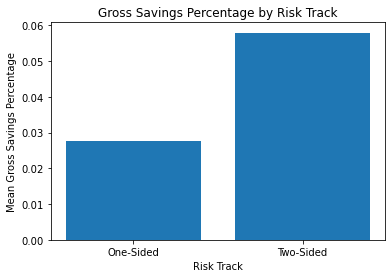

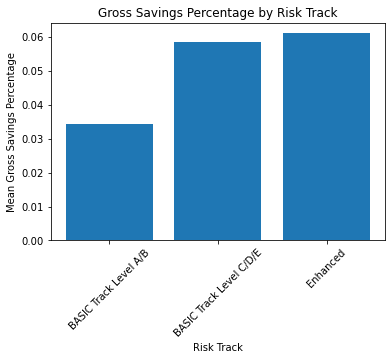

In [169]:
#Do ACOs that take on greater risk see more savings?

x = ["One-Sided", "Two-Sided"]
y = [np.mean(data[data['Risk_Model'] == x[0]]['Sav_rate']), np.mean(data[data['Risk_Model'] == x[1]]['Sav_rate'])]
plt.bar(x, y)
plt.xlabel("Risk Track")
plt.ylabel("Mean Gross Savings Percentage")
plt.title("Gross Savings Percentage by Risk Track")
plt.show()

x = ["BASIC Track Level A/B", "BASIC Track Level C/D/E", "Enhanced"]
y = [np.mean(data[(data['Current_BASIC_A'] == 1) | (data['Current_BASIC_B'] == 1)]['Sav_rate']), 
     np.mean(data[(data['Current_BASIC_C'] == 1) | (data['Current_BASIC_D'] == 1) | (data['Current_BASIC_E'] == 1)]['Sav_rate']),
    np.mean(data[(data['Current_ENHANCED'] == 1)]['Sav_rate'])]
plt.bar(x, y)
plt.xlabel("Risk Track")
plt.ylabel("Mean Gross Savings Percentage")
plt.title("Gross Savings Percentage by Risk Track")
plt.xticks(rotation="45")
plt.show()



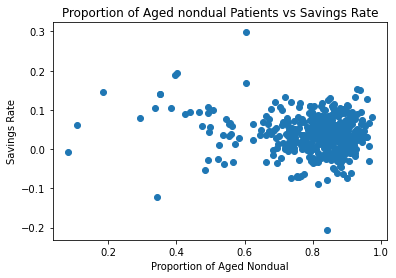

In [176]:
#Do ACOs that see sicker patients (ESRD, disabled, aged-dual) perform worse than ACOs that serve healthier patients?

data['prop_ESRD'] = data['N_AB_Year_ESRD_PY']/data['N_AB_Year_PY']
data['prop_disabled'] = data['N_AB_Year_DIS_PY']/data['N_AB_Year_PY']
data['prop_aged_dual'] = data['N_AB_Year_AGED_Dual_PY']/data['N_AB_Year_PY']
data['prop_aged_nondual'] = data['N_AB_Year_AGED_NonDual_PY']/data['N_AB_Year_PY']

plt.scatter(data['prop_aged_nondual'] , data['Sav_rate'])
plt.title("Proportion of Aged nondual Patients vs Savings Rate")
plt.xlabel("Proportion of Aged Nondual")
plt.ylabel("Savings Rate")
plt.show()


Text(0.5, 1.0, 'Number of Specialists vs Savings Rate')

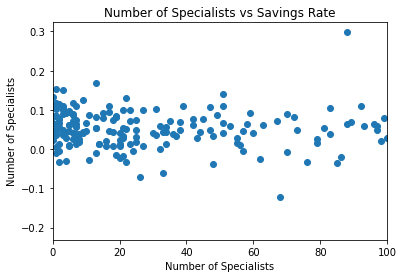

In [210]:
#Do ACOs with more specialists generate more savings?
plt.scatter(data["N_Spec"], data['Sav_rate'])
plt.xlim([0, 100])
plt.xlabel("Savings Rate")
plt.ylabel("Number of Specialists")
plt.title("Number of Specialists vs Savings Rate")

Text(0.5, 1.0, 'PCP Visits vs Savings Rate')

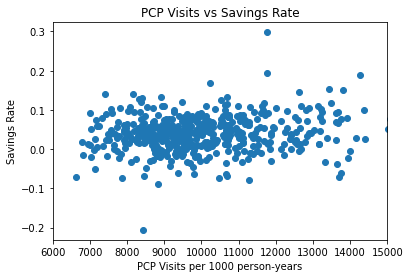

In [200]:
#Do more PCP visits correspond to more savings?
plt.scatter(data["P_EM_Total"], data['Sav_rate'])
plt.xlim([6000, 15000])
plt.xlabel("PCP Visits per 1000 person-years")
plt.ylabel("Savings Rate")
plt.title("PCP Visits vs Savings Rate")

Text(0.5, 1.0, 'Hospital Admissions vs Savings Rate')

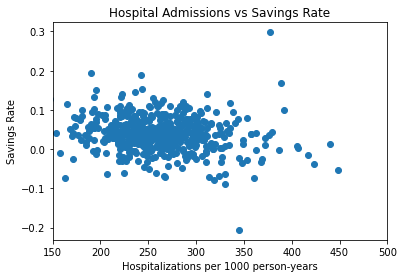

In [202]:
#Do more hospitalizations lead to fewer savings?
plt.scatter(data["ADM"], data['Sav_rate'])
plt.xlim([150, 500])
plt.xlabel("Hospitalizations per 1000 person-years")
plt.ylabel("Savings Rate")
plt.title("Hospital Admissions vs Savings Rate")

### Do total expenditures change with time for each type of patients?

Text(0.5, 1.0, 'Aged/non-dual')

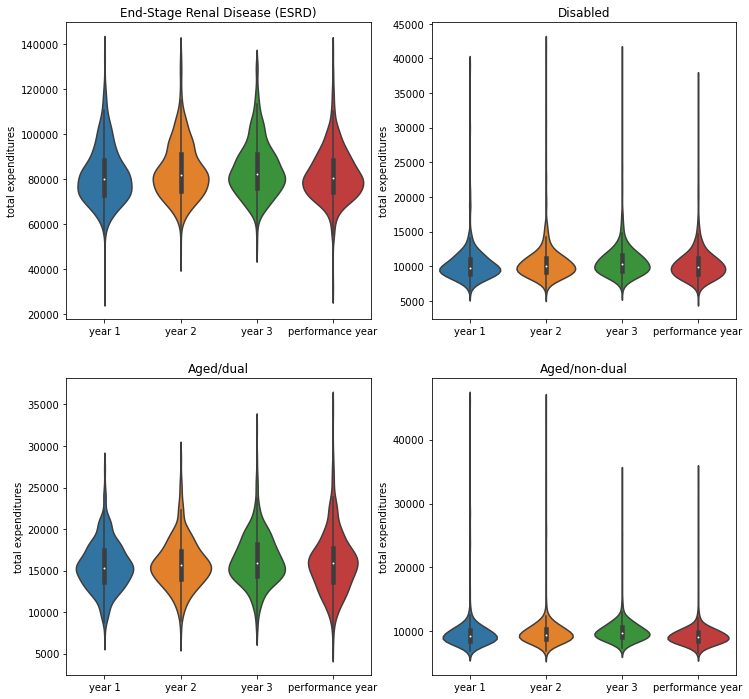

In [214]:
x_esrd = data[['Per_Capita_Exp_ALL_ESRD_BY1', 'Per_Capita_Exp_ALL_ESRD_BY2', 'Per_Capita_Exp_ALL_ESRD_BY3', 'Per_Capita_Exp_ALL_ESRD_PY']]
x_disabled = data[['Per_Capita_Exp_ALL_DIS_BY1', 'Per_Capita_Exp_ALL_DIS_BY2', 'Per_Capita_Exp_ALL_DIS_BY3', 'Per_Capita_Exp_ALL_DIS_PY']]
x_agdu = data[['Per_Capita_Exp_ALL_AGDU_BY1', 'Per_Capita_Exp_ALL_AGDU_BY2', 'Per_Capita_Exp_ALL_AGDU_BY3', 'Per_Capita_Exp_ALL_AGDU_PY']]
x_agnd = data[['Per_Capita_Exp_ALL_AGND_BY1', 'Per_Capita_Exp_ALL_AGND_BY2', 'Per_Capita_Exp_ALL_AGND_BY3', 'Per_Capita_Exp_ALL_AGND_PY']]

fig, ax = plt.subplots(2,2, figsize=(12,12))
sns.violinplot(data=x_esrd, ax=ax[0][0])
ax[0][0].set_xticklabels(['year 1', 'year 2', 'year 3', 'performance year'])
ax[0][0].set_ylabel('total expenditures')
ax[0][0].set_title('End-Stage Renal Disease (ESRD)')
sns.violinplot(data=x_disabled, ax=ax[0][1])
ax[0][1].set_xticklabels(['year 1', 'year 2', 'year 3', 'performance year'])
ax[0][1].set_ylabel('total expenditures')
ax[0][1].set_title('Disabled')
sns.violinplot(data=x_agdu, ax=ax[1][0])
ax[1][0].set_xticklabels(['year 1', 'year 2', 'year 3', 'performance year'])
ax[1][0].set_ylabel('total expenditures')
ax[1][0].set_title('Aged/dual')
sns.violinplot(data=x_agnd, ax=ax[1][1])
ax[1][1].set_xticklabels(['year 1', 'year 2', 'year 3', 'performance year'])
ax[1][1].set_ylabel('total expenditures')
ax[1][1].set_title('Aged/non-dual')

### Do different patient types result in different expenditures?

Text(0.5, 1.0, 'Comparison for different patient type in performance year')

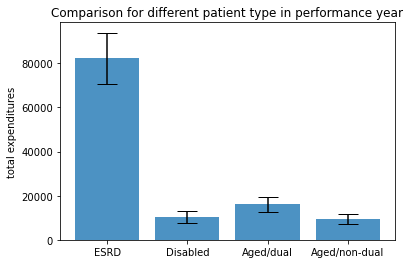

In [215]:
x_type = data[['Per_Capita_Exp_ALL_ESRD_PY', 'Per_Capita_Exp_ALL_DIS_PY', 'Per_Capita_Exp_ALL_AGDU_PY', 'Per_Capita_Exp_ALL_AGND_PY']]
plt.bar(['ESRD', 'Disabled', 'Aged/dual', 'Aged/non-dual'], x_type.mean(), yerr=x_type.std(), align='center', alpha=0.8, ecolor='black', capsize=10)
plt.ylabel('total expenditures')
plt.title('Comparison for different patient type in performance year')

### How does the distribution of the total expenditures look like?

Text(0.5, 1.0, 'Per capita ALL expenditures in performance year')

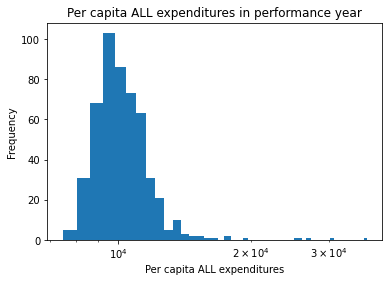

In [216]:
plt.hist(data['Per_Capita_Exp_TOTAL_PY'], bins=50)
plt.xscale('log')
plt.xlabel('Per capita ALL expenditures')
plt.ylabel('Frequency')
plt.title('Per capita ALL expenditures in performance year')

### Participation in the ACO in the performance year

### What is the distribution for medical groups that paticipate in ACO?

Text(0.5, 1.0, 'Total number of the facilities paticipating in ACO')

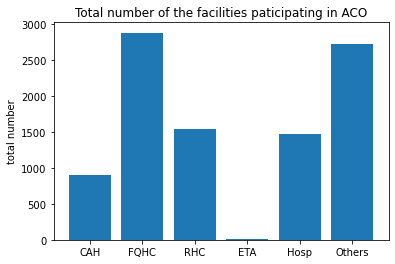

In [218]:
x_group = data[['N_CAH', 'N_FQHC', 'N_RHC', 'N_ETA', 'N_Hosp', 'N_Fac_Other']].sum()
plt.bar(['CAH', 'FQHC','RHC', 'ETA', 'Hosp', 'Others'], x_group)
plt.ylabel('total number')
plt.title('Total number of the facilities paticipating in ACO')

Text(0.5, 1.0, 'Total number of the individuals paticipating in ACO')

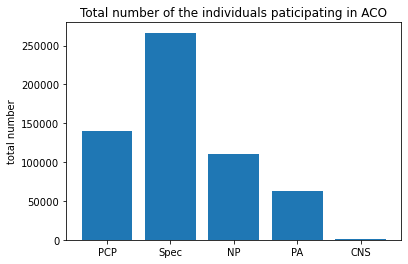

In [219]:
x_group = data[['N_PCP', 'N_Spec', 'N_NP', 'N_PA', 'N_CNS']].sum()
plt.bar(['PCP', 'Spec','NP', 'PA', 'CNS'], x_group)
plt.ylabel('total number')
plt.title('Total number of the individuals paticipating in ACO')

In [ ]:
# Expenditures from several different sources
figure, ax = plt.subplots(1,1, figsize=(15,7))

x_group = data[['CapAnn_INP_S_trm', 'CapAnn_INP_L_trm', 'CapAnn_INP_Rehab', 'CapAnn_INP_Psych', 'CapAnn_HSP', 'CapAnn_SNF']].sum()
plt.bar(['Short term acute care', 'Long term care', 'Inpatient rehabilitation', 'Inpatient psychiatric',  'Hospice','Skilled nursing'], x_group)
plt.ylabel('Total expenditure')
plt.xlabel('Type of expenditure')
plt.title('Expenditures for different categories of hospital care')

In [ ]:
# Do ACOs with a higher proportion of older patients perform worse than ACOs that serve younger patients

figure, axs = plt.subplots(2,2, figsize=(15,12))
axs = axs.ravel()
axs[3].axis('off')

total_patients = data['N_Ben_Age_0_64'] + data['N_Ben_Age_75_84'] + data['N_Ben_Age_75_84'] + data['N_Ben_Age_85plus']
x_list = ['N_Ben_Age_65_74', 'N_Ben_Age_75_84', 'N_Ben_Age_85plus']
labels = ['between 65 and 74', 'between 75 and 84', 'N_Ben_Age_85plus']
for i in range(3):
    axs[i].scatter(data[x_list[i]]/total_patients , data['Sav_rate'], color='b')
    axs[i].set(title="Savings rate vs proportion of patients " + labels[i], xlabel="Proportion of patients in age group", ylabel="Savings Rate");

In [ ]:
# Does a greater amount of ambulance expenditures reduce savings rate
figure, ax = plt.subplots(1,1, figsize=(15,5))
plt.scatter(data["CapAnn_AmbPay"], data['Sav_rate'])
plt.xlabel("Per capita ambulance expenditures")
plt.ylabel("Savings Rate")
plt.title("Savings Rate vs per capital ambulance expenditures")

### Columns with the smallest absolute values

In [ ]:
data.describe().iloc[3].loc[np.abs(data.describe().iloc[3]) <= np.abs(np.mean(data.describe().iloc[3]))]

### Columns with missing values

In [ ]:
data.isnull().sum().loc[data.isnull().sum() > 0]

### How does the saving rate vary with performance year Risk Model?

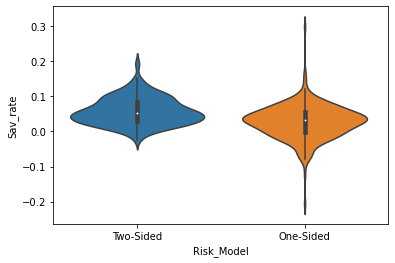

In [220]:
x_risk = data[['Risk_Model', 'Sav_rate']]
fig, ax = plt.subplots()
sns.violinplot(data=x_risk, x='Risk_Model', y='Sav_rate', ax=ax);

### How do average risk scores vary for different patient types accross time?

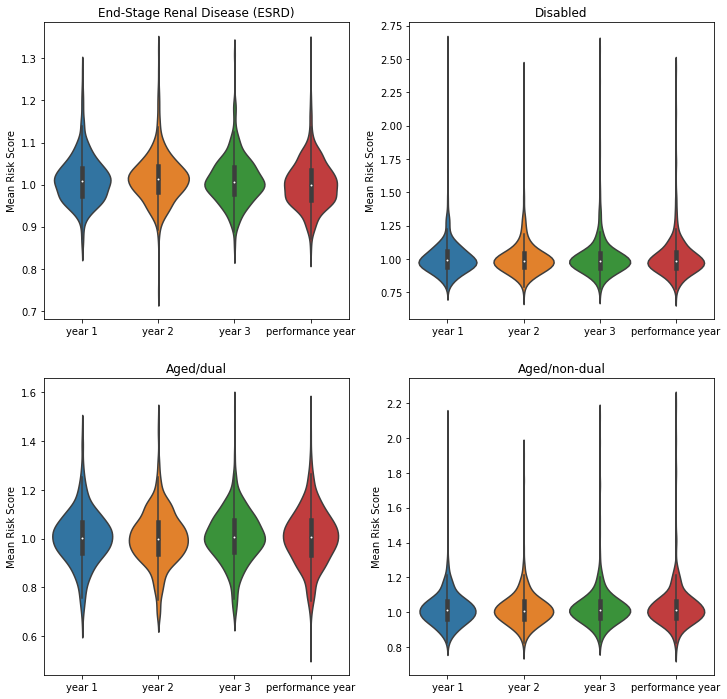

In [222]:
x_esrd = data[['CMS_HCC_RiskScore_ESRD_BY1', 'CMS_HCC_RiskScore_ESRD_BY2', 'CMS_HCC_RiskScore_ESRD_BY3', 'CMS_HCC_RiskScore_ESRD_PY']]
x_dis = data[['CMS_HCC_RiskScore_DIS_BY1', 'CMS_HCC_RiskScore_DIS_BY2', 'CMS_HCC_RiskScore_DIS_BY3', 'CMS_HCC_RiskScore_DIS_PY']]
x_agdu = data[['CMS_HCC_RiskScore_AGDU_BY1', 'CMS_HCC_RiskScore_AGDU_BY2', 'CMS_HCC_RiskScore_AGDU_BY3', 'CMS_HCC_RiskScore_AGDU_PY']]
x_agnd = data[['CMS_HCC_RiskScore_AGND_BY1', 'CMS_HCC_RiskScore_AGND_BY2', 'CMS_HCC_RiskScore_AGND_BY3', 'CMS_HCC_RiskScore_AGND_PY']]

fig, ax = plt.subplots(2,2, figsize=(12,12))
sns.violinplot(data=x_esrd, ax=ax[0][0])
ax[0][0].set_xticklabels(['year 1', 'year 2', 'year 3', 'performance year'])
ax[0][0].set_ylabel('Mean Risk Score')
ax[0][0].set_title('End-Stage Renal Disease (ESRD)')
sns.violinplot(data=x_dis, ax=ax[0][1])
ax[0][1].set_xticklabels(['year 1', 'year 2', 'year 3', 'performance year'])
ax[0][1].set_ylabel('Mean Risk Score')
ax[0][1].set_title('Disabled')
sns.violinplot(data=x_agdu, ax=ax[1][0])
ax[1][0].set_xticklabels(['year 1', 'year 2', 'year 3', 'performance year'])
ax[1][0].set_ylabel('Mean Risk Score')
ax[1][0].set_title('Aged/dual')
sns.violinplot(data=x_agnd, ax=ax[1][1])
ax[1][1].set_xticklabels(['year 1', 'year 2', 'year 3', 'performance year'])
ax[1][1].set_ylabel('Mean Risk Score')
ax[1][1].set_title('Aged/non-dual');

### What services were frequently rendered?

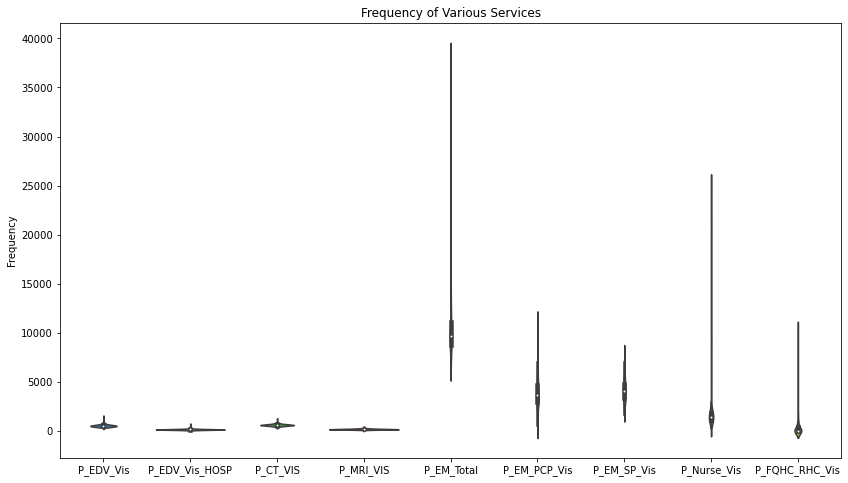

In [221]:
x_services = data[['P_EDV_Vis',
                   'P_EDV_Vis_HOSP',
                   'P_CT_VIS',
                   'P_MRI_VIS',
                   'P_EM_Total',
                   'P_EM_PCP_Vis',
                   'P_EM_SP_Vis',
                   'P_Nurse_Vis',
                   'P_FQHC_RHC_Vis']]
fig, ax = plt.subplots(figsize=(14,8))
sns.violinplot(data=x_services, ax=ax)
ax.set(
    xticklabels = ['P_EDV_Vis',
                   'P_EDV_Vis_HOSP',
                   'P_CT_VIS',
                   'P_MRI_VIS',
                   'P_EM_Total',
                   'P_EM_PCP_Vis',
                   'P_EM_SP_Vis',
                   'P_Nurse_Vis',
                   'P_FQHC_RHC_Vis'],
    ylabel = "Frequency",
    title = "Frequency of Various Services"
);

In [223]:
x_services.describe()

,P_EDV_Vis,P_EDV_Vis_HOSP,P_CT_VIS,P_MRI_VIS,P_EM_Total,P_EM_PCP_Vis,P_EM_SP_Vis,P_Nurse_Vis,P_FQHC_RHC_Vis
count,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000
mean,579.491228,192.695906,648.536062,218.076023,10234.050682,3933.805068,4164.651072,1625.329435,510.237817
std,134.149332,61.827737,104.945015,49.061904,2592.592622,1659.655965,1133.524534,1506.567679,1151.450913
min,287.000000,31.000000,343.000000,39.000000,6641.000000,258.000000,1639.000000,351.000000,0.000000
25%,494.000000,162.000000,586.000000,187.000000,8828.000000,3002.000000,3354.000000,1149.000000,15.000000
50%,561.000000,187.000000,640.000000,213.000000,9723.000000,3659.000000,4127.000000,1467.000000,46.000000
75%,641.000000,216.000000,706.000000,243.000000,11088.000000,4675.000000,4835.000000,1869.000000,418.000000
max,1534.000000,762.000000,1282.000000,481.000000,38057.000000,11256.000000,8136.000000,25304.000000,10496.000000


# Baseline Modelling

In [7]:
#Baseline Model

#all of these are directly tied to the response variable and as such we do not want them as predictors
vars_to_exclude = ["EarnSaveLoss", "GenSaveLoss", "BnchmkMinExp", 'Current_Track_1', 'Current_Track_2', 'Current_Track_3',
                   'Current_Track_1_Plus', 'Current_BASIC_A', 'Current_BASIC_B', 'Current_BASIC_C', 'Current_BASIC_D',
                   'Current_BASIC_E', 'Current_ENHANCED'] 
data_mod = data.drop(vars_to_exclude, axis=1)

#Drop non-relevant categorial columns
cat_cols_to_encode = ["Rev_Exp_Cat", "Risk_Model", "Agree_Type"]
cols = data_mod.columns
num_cols = data_mod._get_numeric_data().columns
vars_to_exclude = list(set(cols) - set(num_cols) - set(cat_cols_to_encode))
data_mod = data_mod.drop(vars_to_exclude, axis=1)

#one-hot encode relevant categorial columns
data_mod = pd.get_dummies(data_mod, columns=cat_cols_to_encode)

nans = ['DisAdj', 'PosRegAdj', 'Adv_Pay_Amt','Adv_Pay_Recoup']
data_mod = data_mod.drop(nans, axis=1)

X = data_mod.drop(['Sav_rate', 'Risk_Model_One-Sided'], axis=1)
y = data_mod['Sav_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=34)

Random Forest Training Score: 0.906
Random Forest Test Score: 0.409


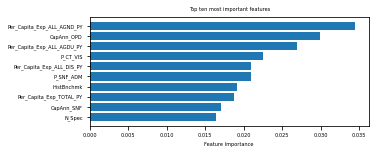

In [8]:
# Create and train Random Forest Regressor
rf = RandomForestRegressor(max_features='sqrt', random_state=30)
rf.fit(X_train, y_train)

print(f"Random Forest Training Score: {rf.score(X_train, y_train):.3f}")
print(f"Random Forest Test Score: {rf.score(X_test, y_test):.3f}")

# Find most important feautres
cols = X.columns
feat_importances = rf.feature_importances_

importance, features = (list(t) for t in zip(*sorted(zip(feat_importances, cols))))

figure, ax = plt.subplots(figsize=(5,2))

ax.barh(np.arange(10), importance[-10: ], align='center', tick_label=features[-10: ])
ax.set_xlabel('Feature Importance', fontsize=5)
ax.set_title('Top ten most important features', fontsize=5)
ax.tick_params(axis='x', labelsize=5)
ax.tick_params(axis='y', labelsize=5)

plt.savefig('Old EDA/Milestone2_images/rf_feature_importance.pdf', bbox_inches="tight")

plt.show()

References:

https://www.cms.gov/files/document/2021-shared-savings-program-fast-facts.pdf

https://www.milliman.com/en/insight/what-predictive-analytics-can-tell-us-about-key-drivers-of-mssp-results-2021-update

https://www.milliman.com/en/insight/-/media/Milliman/PDFs/2021-Articles/8-5-21-Appendix_1_-_predictive-analytics.ashx

https://data.cms.gov/medicare-shared-savings-program/performance-year-financial-and-quality-results

https://www.healthaffairs.org/do/10.1377/hblog20211008.785640/full/

https://www.cms.gov/Medicare/Medicare-Fee-for-Service-Payment/sharedsavingsprogram/Downloads/ssp-aco-participation-options.pdf

https://www.cms.gov/Medicare/Medicare-Fee-for-Service-Payment/sharedsavingsprogram/Downloads/Shared-Savings-Losses-Assignment-Spec-V6.pdf

https://www.investopedia.com/insurance/why-do-healthcare-costs-keep-rising/